<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Trabajo Fin de Máster</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Autor: César Fernández Domínguez</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Análisis descriptivo de datos meteorológicos para la ciudad de Barcelona

Este análisis se ha organizado en los siguientes apartados:

 <ol start="1">
  <li>Carga del conjunto de datos
  <br>1.1 Carga de datos observados en las estaciones meteorológicas de Barcelona
  <br>1.2 Carga de metadatos de variables medidas en las estaciones meteorológicas de Barcelona
  <br>1.3 Carga de datos de estaciones de medida meteorológicas de Barcelona
  <li>Análisis de los datos
  <br>2.1 Análisis estadístico básico
  <br>2.2 Análisis exploratorio de los datos
</ol>
   
En primer lugar, cargamos todas las librerías que vamos a necesitar:

In [1]:
import os, sys
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statistics import mean
%matplotlib inline
pd.set_option('display.max_columns', None)
rcParams['figure.figsize'] = 12, 8
rcParams['font.size'] = 10

# 1. Carga del conjunto de datos

El conjunto de datos analizados en este apartado de compone de los datos meteorológicos registrados en todas las estaciones de la Red de Estaciones Meteorológicas Automáticas (XEMA) del Servicio Meteorológico de Cataluña en la ciudad de Barcelona. Estos datos han sido descargados de la siguiente url: https://analisi.transparenciacatalunya.cat/Medi-Ambient/Dades-meteorol-giques-de-la-XEMA/nzvn-apee. Los datos descargados abarcan desde el 1 de enero de 2010 al 30 de abril del 2020. Las medidas realizadas son recopiladas con una frecuencia inferior a la diaria, generalmente semi-horaria.

Además de estos datos, también necesitaremos, para este análisis, descargar los metadatos para:
- [Información de estaciones meteorológicas automáticas (XEMA)](https://analisi.transparenciacatalunya.cat/d/yqwd-vj5e)
- [Información de cada una de las variables registradas](https://analisi.transparenciacatalunya.cat/d/4fb2-n3yi)

Todos estos datos se ofrecen bajo la licencia: [Propiedad intelectual e industrial de METEOCAT](http://www.meteo.cat/wpweb/avis-legal/)

## 1.1. Carga de datos observados en las estaciones meteorológicas de Barcelona

En este apartado se trata de realizar la carga de los datos observados, que vamos a utilizar para nuestro estudio. Se trata de observaciones de datos meteorológicos registrados, en las estaciones ubicadas dentro de la ciudad de Barcelona, entre el día 1 de enero de 2010 hasta el 31 de abril de 2020. Posiblemente la utilización de todos estos datos penalice en exceso las prestaciones de los modelos que posteriormente serán construidos. Por ese motivo, intentaremos, en la medida de lo posible, aligerar este volumen de datos.

Estos datos se ofrecen con Licencia: [Open Data Commons Attribution License](https://opendatacommons.org/licenses/by/1.0/)

El siguiente código nos permite cargar los datos meteorológicos, disponibles entre dos meses, en la ciudad de Barcelona (los datos predescargados están filtrados para Barcelona) . Para ello, debemos modificar los valores asignados a las variables 'dataStartTime' y 'dataEndTime'.

In [2]:
dataStartTime = "2010-01"
dataEndTime = "2020-04"

# Header definition
columns=['id', 'codi_estacio', 'codi_variable', 'data_lectura', 'data_extreme', 'valor_lectura', 'codi_estat', 'codi_base']
dtype={'id':object, 'codi_estacio':object, 'codi_variable':object, 'data_lectura':object, 
       'data_extreme':object, 'valor_lectura':np.number, 'codi_estat':object, 'codi_base':object}
       
# Read data to dataframe
data_meteo = pd.DataFrame(columns=columns)
for time in pd.date_range(dataStartTime+"-01T00:00:00.000", dataEndTime+"-01T00:00:00.000", freq='MS'):
    filename = time.strftime("../data/meteo/meteo_%Y_%m.zip")
    sys.stdout.write(200*' '+'\r')
    sys.stdout.write('Reading file: \x1b[31m{}\x1b[0m \r'.format(filename))
    sys.stdout.flush()
    data_meteo = data_meteo.append(
        #pd.read_csv(filename, names=columns, sep=';', encoding = "ISO-8859-1", dtype=dtype)
        pd.read_csv(filename, names=columns, sep=';', encoding = "UTF-8", dtype=dtype)
        , ignore_index = True)

In [3]:
data_meteo.shape

(4883615, 8)

Comprobamos que no se ha cargado ninguna instancia repetida. Si así fuera, tendríamos que eliminar aquellas que se repitan.

In [4]:
# Check whether duplicated rows and remove them, if so
duplicateRowsDF = data_meteo[data_meteo.duplicated()]
if len(duplicateRowsDF):
    data_meteo.drop_duplicates(inplace=True)  
    
print("Número de instancias duplicadas eliminadas: %d" % (len(duplicateRowsDF))) 

Número de instancias duplicadas eliminadas: 0


Mostramos las primeras instancias de nuestro dataframe para ver cómo son nuestros datos:

In [5]:
# Show first values in dataframe
data_meteo.head()

,id,codi_estacio,codi_variable,data_lectura,data_extreme,valor_lectura,codi_estat,codi_base
0,X4030101100000,X4,3,2010-01-01T00:00:00.000,2010-01-01T00:03:00.000,46.0,V,HO
1,X4720101100000,X4,72,2010-01-01T00:00:00.000,2010-01-01T00:00:00.000,0.0,V,HO
2,X4420101100000,X4,42,2010-01-01T00:00:00.000,2010-01-01T00:56:00.000,11.8,V,HO
3,X4320101100000,X4,32,2010-01-01T00:00:00.000,NaN,12.1,V,HO
4,X4400101100000,X4,40,2010-01-01T00:00:00.000,2010-01-01T00:00:00.000,12.4,V,HO


Vemos como los datos están organizados en 8 columnas, que son:

- 'id', que establece un código de identificación único para cada instancia.
- 'codi_estacio', código identificador de la Estación Meteorológica Automática (asociado con el primer fichero de metadatos anterior).
- 'codi_variable', código identificador de la variable meteorológica (asociado con el segundo fichero de metadatos anterior).
- 'data_lectura', fecha y hora inicial de la lectura (los registros se encuentran etiquetados por delante). La hora se facilita en Tiempo Universal (UTC).
- 'data_extreme', fecha y hora en que se ha registrado el valor máximo o mínimo. La hora se facilita en Tiempo Universal (UTC). Este campo sólo aparece en variables extremas.
- 'valor_lectura', valor de la variable meteorológica.
- 'codi_estat', atributo que informa del resultado del proceso de validación. Los posibles atributos son: espacio en blanco (el dato no ha iniciado el proceso de validación), T (el proceso de validación se ha iniciado, pero no ha finalizado), V (dato válido). Los valores no válidos no se muestran.
- 'codi_base', base temporal en que se ha medido la variable meteorológica. La base temporal puede ser HO (horaria) o SH (semi-horaria).

En nuestro caso, los datos descargados solamente incluyen valores registrados en las estaciones ubicadas en Barcelona. Que, como vimos anteriormente, son cuatro:

In [6]:
data_meteo['codi_estacio'].unique()

array(['X4', 'X8', 'X2', 'D5'], dtype=object)

## 1.2. Carga de metadatos de variables medidas en las estaciones meteorológicas de Barcelona

Para tener un conocimiento claro de cada uno los datos meteorológicos registrados, se proporciona un fichero de metadatos con la definición de cada una de las variables registradas en las estaciones meteorológicas. No todas las variables son registradas en todas las estaciones, sino que dependerá de la instrumentación instalada en cada una de ellas.

Seguidamente, cargamos el fichero de metadatos de las estaciones meteorológicas previamente descargado.

In [7]:
# Read meteo variables metadata file
meteoVariablesPath='../data/meteo/meta/meteo_variables.json'
if not os.path.exists(meteoVariablesPath):
     meteoVariablesPath='https://analisi.transparenciacatalunya.cat/resource/4fb2-n3yi.json'
meteoVariables=pd.read_json(meteoVariablesPath, orient='records', encoding='utf-8')
meteoVariables

,acronim,codi_tipus_var,codi_variable,decimals,nom_variable,unitat
0,PPTx1min,DAT,72,1,Precipitació màxima en 1 minut,mm
1,HRx,DAT,3,0,Humitat relativa màxima,%
2,VV10,DAT,30,1,Velocitat del vent a 10 m (esc.),m/s
3,DV10,DAT,31,0,Direcció de vent 10 m (m. 1),°
4,T,DAT,32,1,Temperatura,°C
5,HR,DAT,33,0,Humitat relativa,%
6,P,DAT,34,1,Pressió atmosfèrica,hPa
7,PPT,DAT,35,1,Precipitació,mm
8,RS,DAT,36,0,Irradiància solar global,W/m²
9,GNEU,DAT,38,0,Gruix de neu a terra,mm


Vemos que tenemos 26 variables distintas, relativas a datos relacionados con la meteorología. Para cada variable se distinguen varios campos que hacen relación a:

- Campo 'acronim', que incluye el acrónimo asociado a cada variable.
- Campo 'codi_tipus_var', código del tipo de variable.
- Campo 'codi_variable', código identificador de cada variable.
- Campo 'decimals', cantidad de números decimales
- Campo 'nom_variable', nombre completo de la variable.
- Campo 'unitat', unidad de medida de las variables.

Esta tabla la utiliceremos posteriormente para identificar, de una forma más reconocible, cada una de las variables observadas.

## 1.3. Carga de datos de estaciones de medida meteorológicas de Barcelona

Otro fichero de metadatos que se nos proporciona, es un listado de las estaciones meteorológicas automáticas (XEMA) del servicio meteorológico de Cataluña. Esta red de estaciones se compone de más de 230 estaciones de observación. A través del servicio de datos abiertos de Cataluña, en la url mencionada arriba, se ofrece un fichero con información de cada una de estas estaciones.

Si cargamos el fichero que previamente hemos descargado de la página web anterior, obtenemos la siguiente tabla:

In [8]:
# Read meteo stations metadata file
meteoStationsPath='../data/meteo/meta/meteo_stations.json'
if not os.path.exists(meteoStationsPath):
    meteoStationsPath='https://analisi.transparenciacatalunya.cat/resource/yqwd-vj5e.json'
meteoStations=pd.read_json(meteoStationsPath, orient='records', encoding='UTF-8')

Como vemos, este fichero consta de 233 filas y 22 columnas. Las primeras hacen referencia a cada una de las estaciones incluidas en el fichero y, la segundas son cada uno de los metadatos definidos para cada estación.

In [9]:
meteoStations.shape

(233, 22)

A continuación, vemos las primeras estaciones definidas en la tabla cargada:

In [10]:
meteoStations.head()

,:@computed_region_bh64_c7uy,:@computed_region_wvic_k925,altitud,codi_comarca,codi_estacio,codi_estat_ema,codi_municipi,codi_provincia,codi_tipus,codi_xarxa,data_fi,data_inici,emplacament,geocoded_column,latitud,longitud,nom_comarca,nom_estacio,nom_estat_ema,nom_municipi,nom_provincia,nom_xarxa
0,375.0,30.0,240.0,1,VY,2,12,43,A,1,NaN,2000-09-18T00:00:00.000,Cooperativa agrària,"{'type': 'Point', 'coordinates': [1.29863, 41....",41.25095,1.29863,Alt Camp,Nulles,Operativa,Nulles,Tarragona,XEMA
1,294.0,10.0,433.0,19,YB,2,443,17,A,1,NaN,2016-07-21T00:00:00.000,Pla de Dalt,"{'type': 'Point', 'coordinates': [2.47097, 42....",42.18813,2.47097,Garrotxa,Olot,Operativa,Olot,Girona,XEMA
2,512.0,29.0,33.0,13,X4,2,332,8,A,1,NaN,2006-10-11T00:00:00.000,Facultat de Geografia i Història. c. Montalegr...,"{'type': 'Point', 'coordinates': [2.16775, 41....",41.38390,2.16775,Barcelonès,Barcelona - el Raval,Operativa,Barcelona,Barcelona,XEMA
3,335.0,2.0,954.0,26,YG,2,634,25,A,1,NaN,2018-01-11T00:00:00.000,Heliport de Tírvia,"{'type': 'Point', 'coordinates': [1.24244, 42....",42.51881,1.24244,Pallars Sobirà,Tírvia,Operativa,Tírvia,Lleida,XEMA
4,522.0,25.0,44.5,21,DD,1,513,8,A,1,2015-01-16T00:00:00.000,1998-05-04T00:00:00.000,"Soc.Civil d'Aigües ""La Mina Vella","{'type': 'Point', 'coordinates': [2.38674, 41....",41.51175,2.38674,Maresme,Vilassar de Mar,Desmantellada,Vilassar de Mar,Barcelona,XEMA


In [11]:
meteoStations.columns

Index([':@computed_region_bh64_c7uy', ':@computed_region_wvic_k925', 'altitud',
       'codi_comarca', 'codi_estacio', 'codi_estat_ema', 'codi_municipi',
       'codi_provincia', 'codi_tipus', 'codi_xarxa', 'data_fi', 'data_inici',
       'emplacament', 'geocoded_column', 'latitud', 'longitud', 'nom_comarca',
       'nom_estacio', 'nom_estat_ema', 'nom_municipi', 'nom_provincia',
       'nom_xarxa'],
      dtype='object')

Como podemos observar en la tabla anterior, se incluyen distintos valores para cada una de las estaciones. En nuestro caso, solamente nos interesan los campos: 

- El campo 'nom_municipi', para filtrar únicamente por aquellas estaciones ubiadas en la ciudad de Barcelona.
- El campo 'nom_estat_ema', para filtrar por aquellas estaciones que estén operativas actualmente.
- Los campos 'latitud' y 'longitud', para obtener las coordenadas geográficas de cada una de las estaciones.
- El campo 'data_inici', para asegurarnos de que tenemos datos desde inicio del año 2010, a partir del cual se realiza este trabajo.
- El campo 'codi_estacio', para obtener el código de identificación asignado a cada estación.
- El campo 'emplacament', que nos proporciona la ubicación de la estación dentro del callejero de la ciudad.

Así, con estos campos, obtenemos la siguiente tabla más reducida con únicamente las estaciones en Barcelona:

In [12]:
# Aggregate by most frequent value
data_meteo_stations=meteoStations.loc[(meteoStations['nom_municipi'] == 'Barcelona'), 
                  ['codi_estacio','emplacament','nom_estat_ema','data_inici','data_fi','latitud','longitud']]
data_meteo_stations

,codi_estacio,emplacament,nom_estat_ema,data_inici,data_fi,latitud,longitud
2,X4,Facultat de Geografia i Història. c. Montalegr...,Operativa,2006-10-11T00:00:00.000,NaN,41.38390,2.16775
65,AN,Av. Lluís Companys (Ciutadella),Desmantellada,1992-05-11T00:00:00.000,2002-10-29T00:00:00.000,41.39004,2.18091
74,X8,Pistes UB,Operativa,2008-04-17T00:00:00.000,NaN,41.37919,2.10540
164,X2,Zoo,Operativa,2006-09-22T00:00:00.000,NaN,41.38943,2.18847
221,D5,Observatori Fabra,Operativa,1995-11-03T00:00:00.000,NaN,41.41843,2.12388


Vemos que tenemos cinco estaciones, pero una de ellas fué desmantelada en el año 2002. Por lo tanto, no contiene datos que nos puedan ser útiles para nuestro estudio. Filtramos también para aquellas estaciones actualmente operativas:

In [13]:
# Aggregate by most frequent value
data_meteo_stations=meteoStations.loc[(meteoStations['nom_estat_ema'] == 'Operativa') & (meteoStations['nom_municipi'] == 'Barcelona'), 
                  ['codi_estacio','emplacament','nom_estat_ema','data_inici','data_fi','latitud','longitud']]
data_meteo_stations

,codi_estacio,emplacament,nom_estat_ema,data_inici,data_fi,latitud,longitud
2,X4,Facultat de Geografia i Història. c. Montalegr...,Operativa,2006-10-11T00:00:00.000,NaN,41.38390,2.16775
74,X8,Pistes UB,Operativa,2008-04-17T00:00:00.000,NaN,41.37919,2.10540
164,X2,Zoo,Operativa,2006-09-22T00:00:00.000,NaN,41.38943,2.18847
221,D5,Observatori Fabra,Operativa,1995-11-03T00:00:00.000,NaN,41.41843,2.12388


Para hacernos una idea de la ubicación de cada una de estas estaciones hemos incluido el siguiente mapa, donde se marca su posición exacta según sus coordenadas geográficas:

In [14]:
lon=data_meteo_stations['longitud'].tolist()
lat=data_meteo_stations['latitud'].tolist()

# Create a Map instance
m = folium.Map(location=[mean(lat), mean(lon)], 
               width=1250, height=700,
               zoom_start=13, min_zoom=13, max_zoom=13, 
               control_scale=False, zoom_control=False)

for index, row in data_meteo_stations.iterrows():
    text='<b>{}</b><br>From: {}<br>Code station: <b>{}</b>'.format(row['emplacament'],row['data_inici'],row['codi_estacio'])
    folium.Marker(
        location=[row['latitud'], row['longitud']], 
        tooltip=text,
        icon=folium.Icon(color='green', icon='cloud'),
    ).add_to(m)
m

En el siguiente apartado vamos a realizar un análisis de estos datos.

# 2. Análisis de los datos



## 2.1 Análisis estadístico básico

Veamos como se distribuyen los datos de nuestro dataframe. 

En primer lugar vemos la distribución de las variables categóricas:

In [15]:
data_meteo.describe(include='O')

,id,codi_estacio,codi_variable,data_lectura,data_extreme,codi_estat,codi_base
count,4883615,4883615,4883615,4883615,2532461,4862395,4883615
unique,4883615,4,16,90481,1384580,2,2
top,D5502810130900,X4,32,2012-06-18T13:00:00.000,2014-11-25T07:00:00.000,V,SH
freq,1,1447578,361868,54,17,4861099,4065596


Como vemos en esta tabla, nuestros datos se corresponden a 16 variables meteorológicas distintas, registradas en 4 estaciones. La información dada en esta tabla para las columnas 'data_lectura' y 'data_extreme' no son muy relevantes. Basicamente nos indican el número de horas de registro de medida distintos en nuestro conjunto de datos. La columna 'codi_estat', nos indica el estado de verificación de cada una de las medidas registradas. Puesto que, tal y como se dice arriba, no se incluyen aquellas medidas que no son consideradas válidas, ya sea por un defecto en el equipo de medida o cualquier otra razón, podríamos considerar que todos los valores en el campo 'valor_lectura' son válidos (cabe considerar que en el momento de descarga de los datos estos ya han pasado por la fase de verificación).

A continuación, mostramos también los estadísticos básicos para la única columna cualitativa 'valor_lectura'. Sin embargo, por ahora, estos resultados no tienen ninguna validez, pues están calculados incluyendo los valores observados para todas las variables meteorológicas.

In [16]:
data_meteo.describe()

,valor_lectura
count,4.883615e+06
mean,2.171834e+02
std,3.615947e+02
min,-4.700000e+00
25%,7.200000e+00
50%,4.100000e+01
75%,1.950000e+02
max,1.148000e+03


Vamos a realizar algunas transformaciones en los datos para que nos sea más fácil trabajar con ellos. 

En primer lugar, vamos a modificar el campo 'codi_variable' para que contenga el acrónimo que tiene asignado según los metadatos que vimos anteriormente:

In [17]:
for index, row in meteoVariables.iterrows():
    data_meteo.loc[data_meteo['codi_variable'] == str(row['codi_variable']),['codi_variable']] = str(row['acronim'])
data_meteo.head()

,id,codi_estacio,codi_variable,data_lectura,data_extreme,valor_lectura,codi_estat,codi_base
0,X4030101100000,X4,HRx,2010-01-01T00:00:00.000,2010-01-01T00:03:00.000,46.0,V,HO
1,X4720101100000,X4,PPTx1min,2010-01-01T00:00:00.000,2010-01-01T00:00:00.000,0.0,V,HO
2,X4420101100000,X4,Tn,2010-01-01T00:00:00.000,2010-01-01T00:56:00.000,11.8,V,HO
3,X4320101100000,X4,T,2010-01-01T00:00:00.000,NaN,12.1,V,HO
4,X4400101100000,X4,Tx,2010-01-01T00:00:00.000,2010-01-01T00:00:00.000,12.4,V,HO


Vemos como ahora ya no nos aparecen esos códigos númericos que no nos aclaraban demasiado sobre el tipo de dato contenido en cada instancia/fila.

El siguiente paso va a ser pivotar los datos para que nos aparezcan en una nueva tabla, en donde los valores de lectura se colocan en columnas distintas para cada variable observada:

In [18]:
data_meteo_hourly=data_meteo.reset_index().groupby(['codi_estacio','data_lectura','codi_variable'])['valor_lectura'].aggregate('first').unstack()
data_meteo_hourly = data_meteo_hourly.reset_index().sort_values(by='data_lectura')
data_meteo_hourly.shape

(361921, 18)

Vemos como ahora nuestro nuevo dataframe tiene una estructura distinta, con 18 columnas, una para cada variable observada, más una columna incluyendo el código de la estación donde han sido medidos y otra columna con la fecha de la lectura. El número de instancias también se ha visto modificado.

In [19]:
data_meteo_hourly.head()

codi_variable,codi_estacio,data_lectura,DV10,DVVx10,HR,HRn,HRx,P,PPT,PPTx1min,Pn,Px,RS,T,Tn,Tx,VV10,VVx10
0,D5,2010-01-01T00:00:00.000,235.0,261.0,57.0,56.0,58.0,946.0,0.0,0.0,946.0,947.0,0.0,8.2,8.0,8.3,9.7,17.3
271440,X8,2010-01-01T00:00:00.000,273.0,276.0,50.0,49.0,51.0,985.0,0.0,0.0,985.0,986.0,0.0,11.2,11.0,11.4,6.1,11.1
180959,X4,2010-01-01T00:00:00.000,276.0,280.0,44.0,43.0,46.0,990.0,0.0,0.0,990.0,991.0,0.0,12.1,11.8,12.4,5.7,15.6
90481,X2,2010-01-01T00:00:00.000,NaN,NaN,46.0,45.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN,12.4,12.1,12.7,NaN,NaN
271441,X8,2010-01-01T01:00:00.000,282.0,259.0,49.0,49.0,50.0,986.0,0.0,0.0,985.0,986.0,0.0,10.5,10.4,10.7,5.6,12.1


Si vemos ahora la distribución de las variables cualitativas y cuantitativas del nuevo dataframe tenemos que:

In [20]:
data_meteo_hourly.describe(include='O')

codi_variable,codi_estacio,data_lectura
count,361921,361921
unique,4,90481
top,X8,2015-04-22T16:00:00.000
freq,90481,4


Seguimos teniendo datos de cuatro estaciones meteorológicas distintas y, el número de hora de lectura distintas es practicamente igual al total de instancias dividido por el número de estaciones.

Para las variables cualitativas, la tabla de abajo, ahora sí refleja los valores estadísticos válidos para los datos registrados de cada variable meteorológica en todas las estaciones consideradas.

In [21]:
stats=data_meteo_hourly.describe()
stats

codi_variable,DV10,DVVx10,HR,HRn,HRx,P,PPT,PPTx1min,Pn,Px,RS,T,Tn,Tx,VV10,VVx10
count,271032.000000,271120.000000,361868.000000,361832.000000,361839.000000,271409.000000,271443.000000,271301.000000,271376.000000,271330.000000,271248.000000,361868.000000,361832.000000,361832.000000,271162.000000,271123.000000
mean,198.117750,199.558789,66.175821,64.119625,68.189338,995.917322,0.041517,0.006756,995.742900,996.093091,184.099662,16.651368,16.343925,16.973954,2.785821,5.314227
std,96.363206,98.616227,16.512768,16.936738,16.130575,20.666008,0.521915,0.058590,20.669797,20.660865,270.641511,6.381440,6.338946,6.433401,2.005215,3.016584
min,0.000000,0.000000,6.000000,5.000000,7.000000,932.700000,0.000000,0.000000,932.500000,932.900000,-4.000000,-4.600000,-4.700000,-4.400000,0.000000,0.000000
25%,108.000000,108.000000,55.000000,52.000000,57.000000,972.600000,0.000000,0.000000,972.500000,972.800000,0.000000,11.700000,11.400000,12.000000,1.400000,3.100000
50%,219.000000,220.000000,67.000000,65.000000,69.000000,1005.200000,0.000000,0.000000,1005.100000,1005.400000,5.000000,16.200000,15.900000,16.500000,2.300000,4.800000
75%,281.000000,286.000000,78.000000,77.000000,80.000000,1011.900000,0.000000,0.000000,1011.800000,1012.100000,318.000000,21.700000,21.400000,22.000000,3.700000,7.000000
max,359.000000,360.000000,100.000000,100.000000,100.000000,1036.200000,58.700000,4.900000,1036.000000,1036.400000,1148.000000,38.600000,38.200000,39.800000,18.200000,31.700000


Guardaremos estos datos en un fichero por si lo necesitaramos para estudios posteriores.

In [22]:
data_meteo_hourly.to_csv(r'../data/data_meteo_hourly.csv', index = False)

## 2.2 Análisis exploratorio de los datos

Hasta ahora hemos visto como están organizados nuestros datos y analizado los estadísticos básicos de estos. Ahora vamos a explorar visualmente como es la distribución de nuestros datos y como varian en el tiempo.

En primer lugar, representamos gráficamente, en forma de boxplot, como se distribuyen los datos observados, en todas las estaciones, para cada una de las variables.

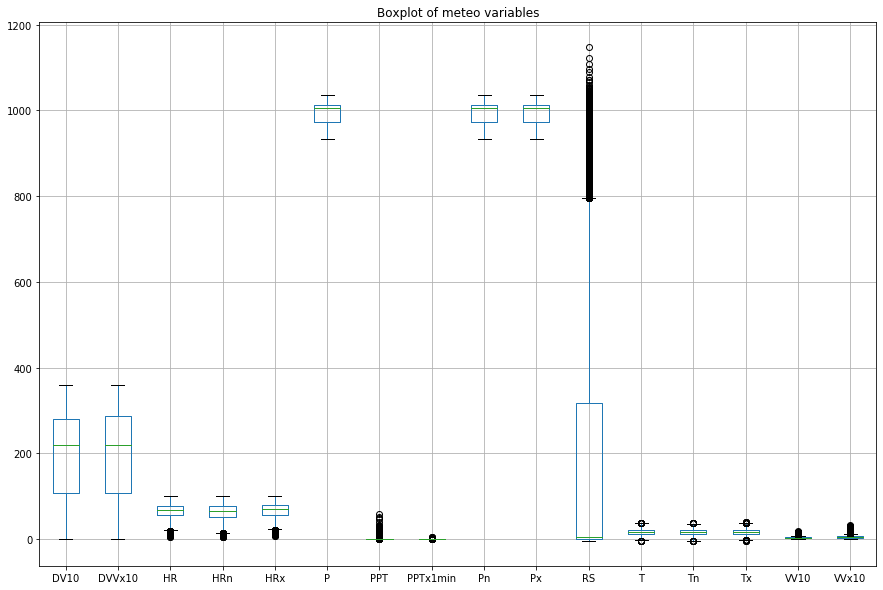

In [23]:
axes=data_meteo_hourly.boxplot(figsize=(15,10))
plt.title("Boxplot of meteo variables")
plt.show()

La misma información la podemos representar agrupando los datos para cada variable por estaciones.

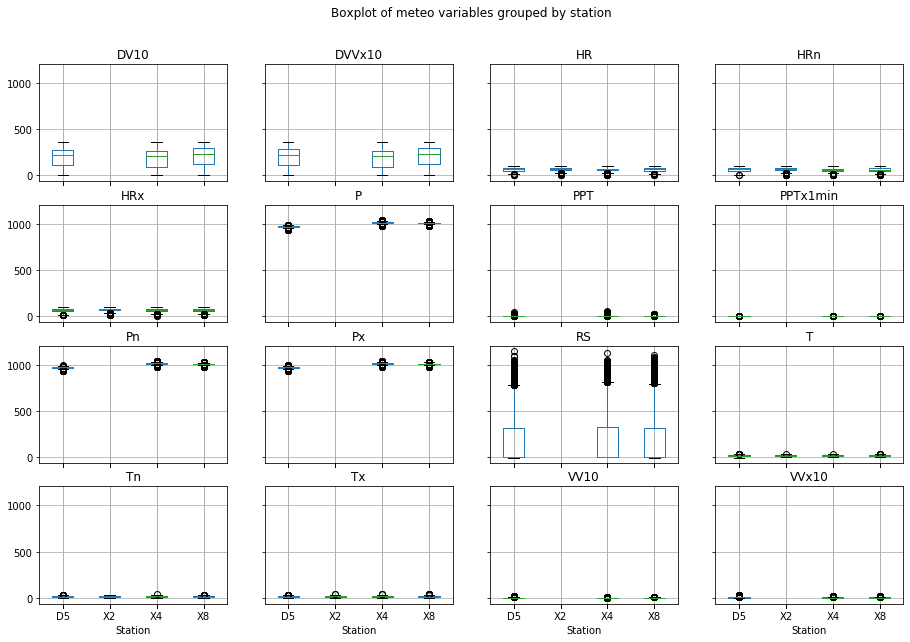

In [24]:
bp=data_meteo_hourly.boxplot(by=['codi_estacio'],figsize=(15,10))
[ax_tmp.set_xlabel('Station') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
fig.suptitle('Boxplot of meteo variables grouped by station')
plt.show()

Podemos observar, en estas figuras, la presencia de valores extremos. Sin embargo, en nuestro caso, optaremos por mantener estos datos, pues se entiende que son valores correctamente observados y válidos.

Ahora vamos a ver cómo es la variación de cada una de las variables en el tiempo. Para realizar esto lo primero que hacemos es transformar la columna 'data_lectura', que recoge la fecha y hora de captura de cada medida, en un formato DatetimeIndex. Esto nos permitirá, entre otras cosas, representar el eje de tiempo de una forma más entendible o, alterar la frecuencia de los datos analizados.

In [25]:
data_meteo_hourly['data_lectura'] = pd.DatetimeIndex(data_meteo_hourly['data_lectura'])

En el siguiente grupo de gráficas, mostramos la variación de cada variable meteorológica comparando entre las distintas estaciones.

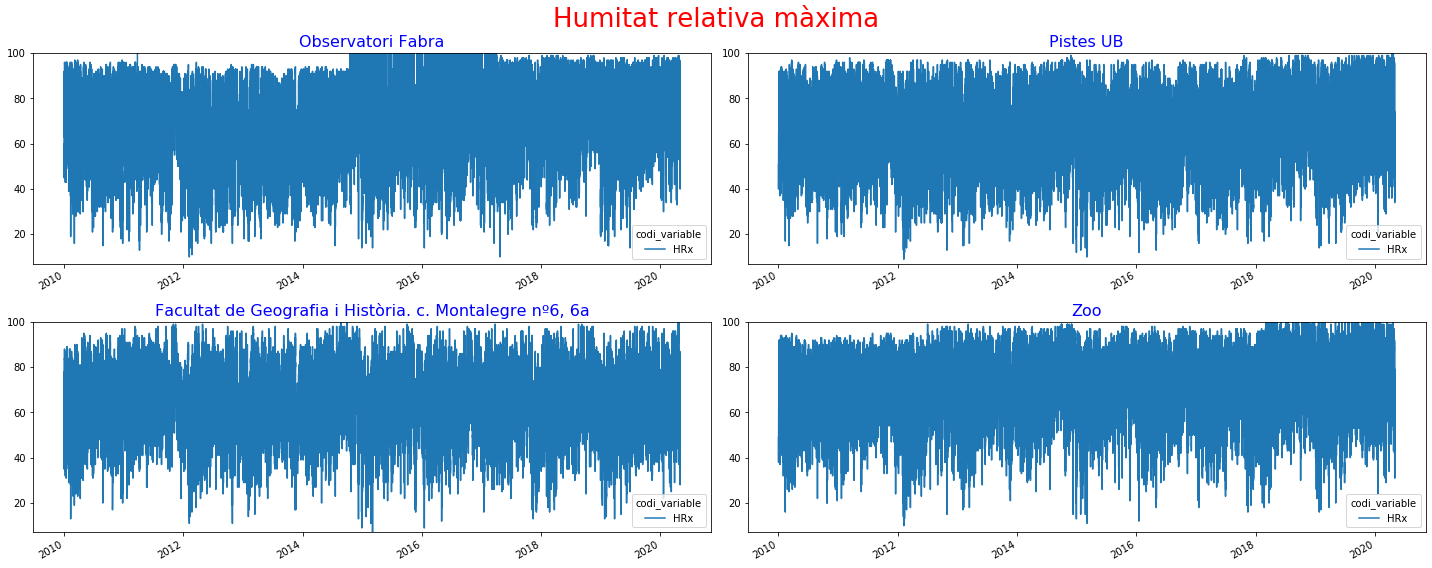

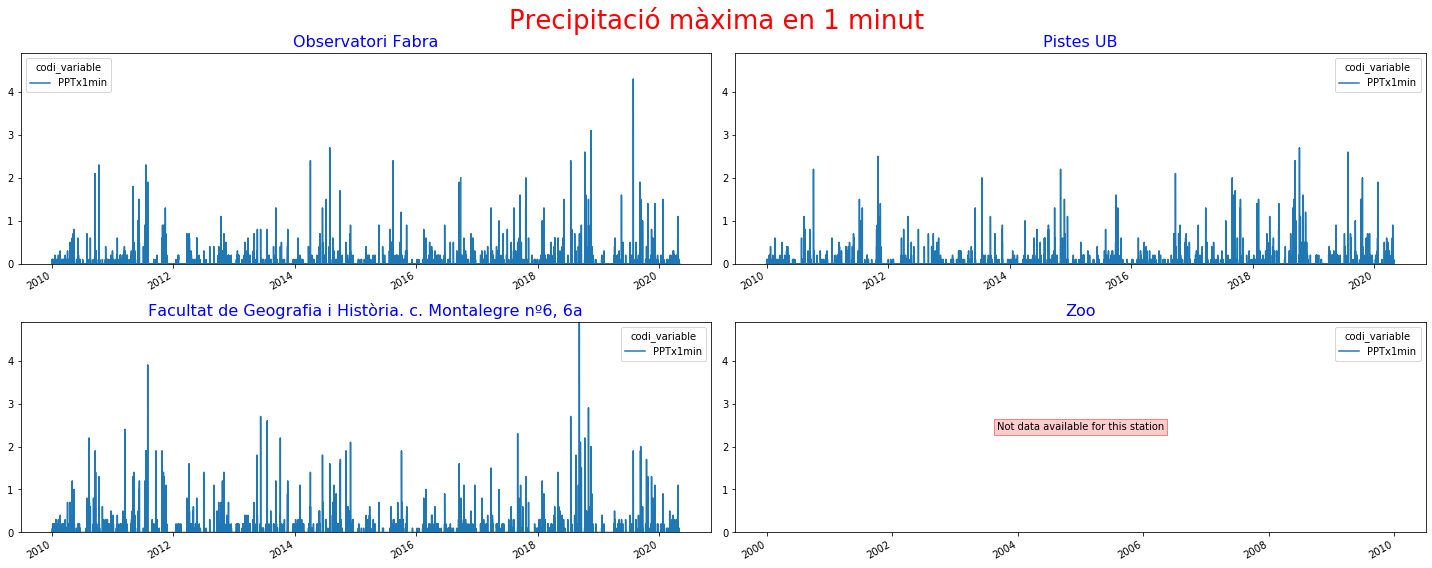

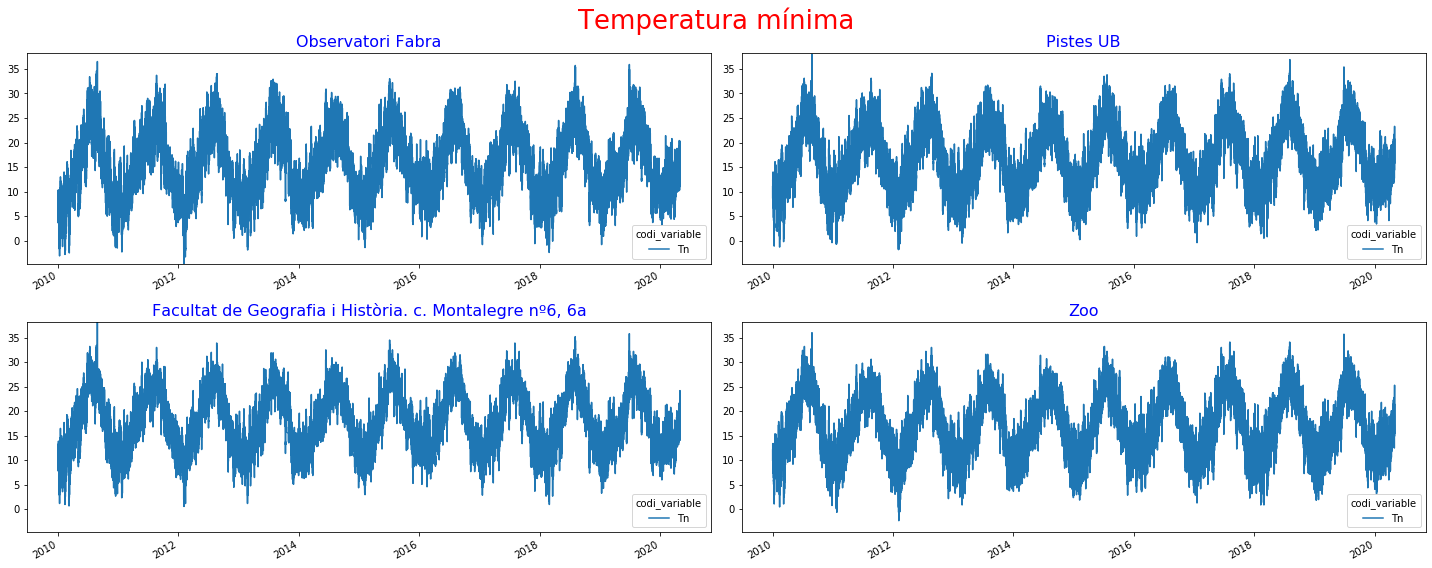

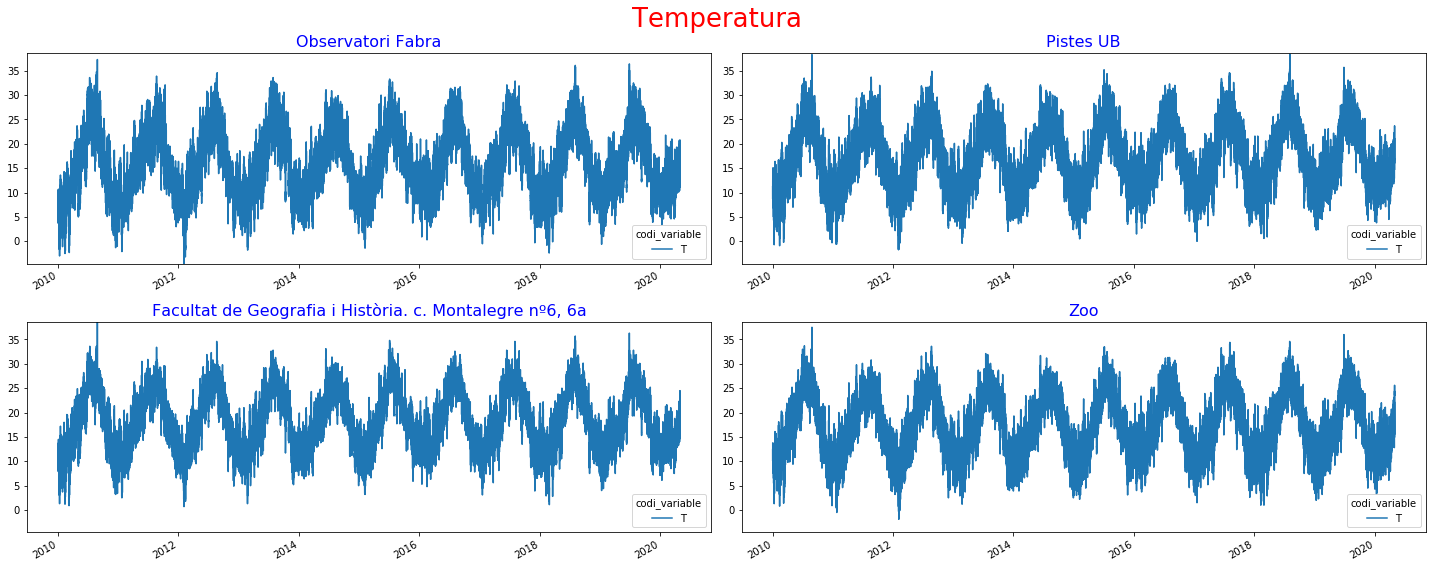

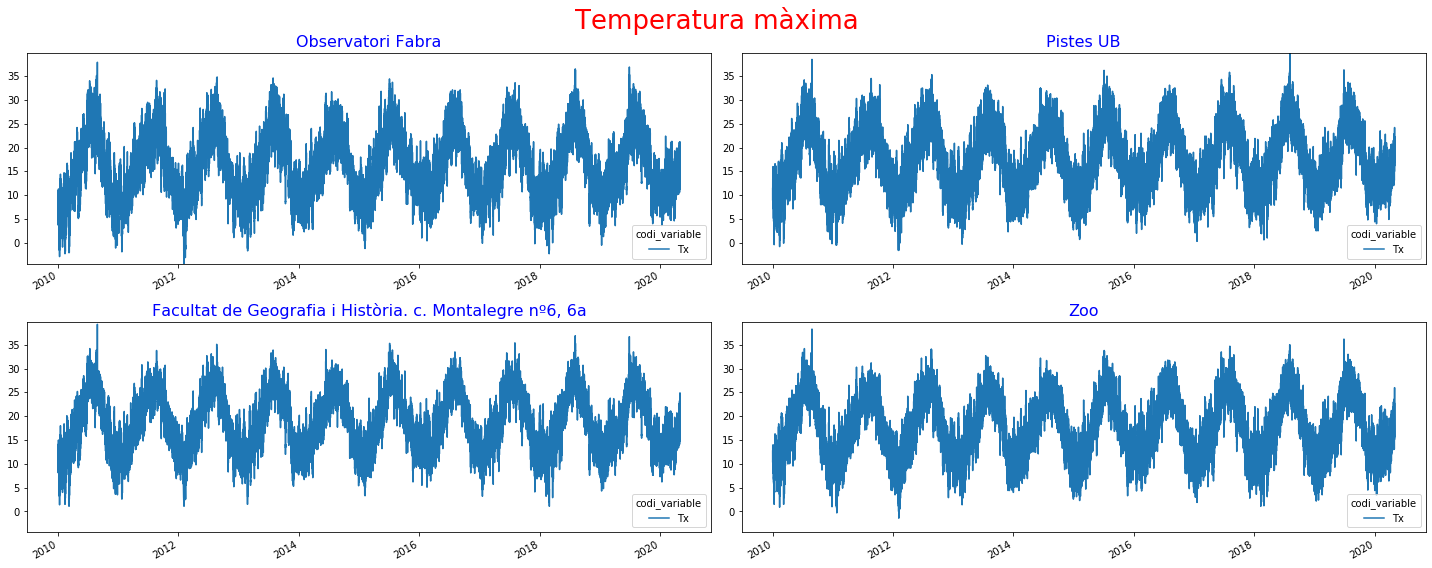

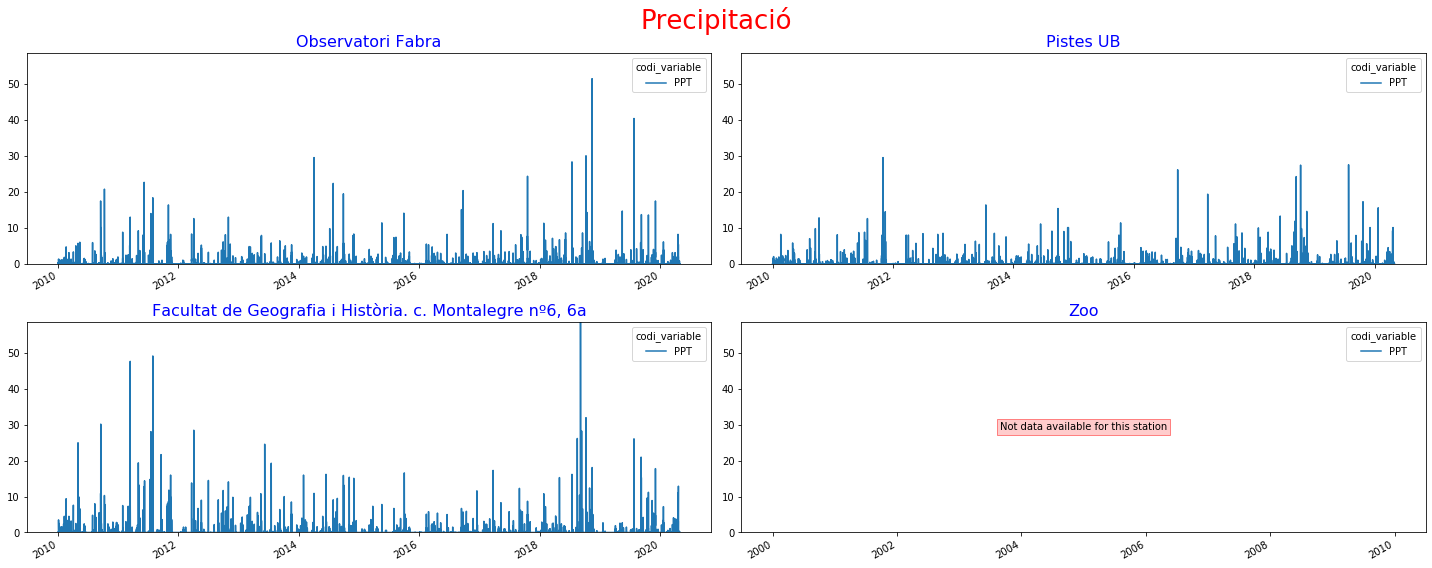

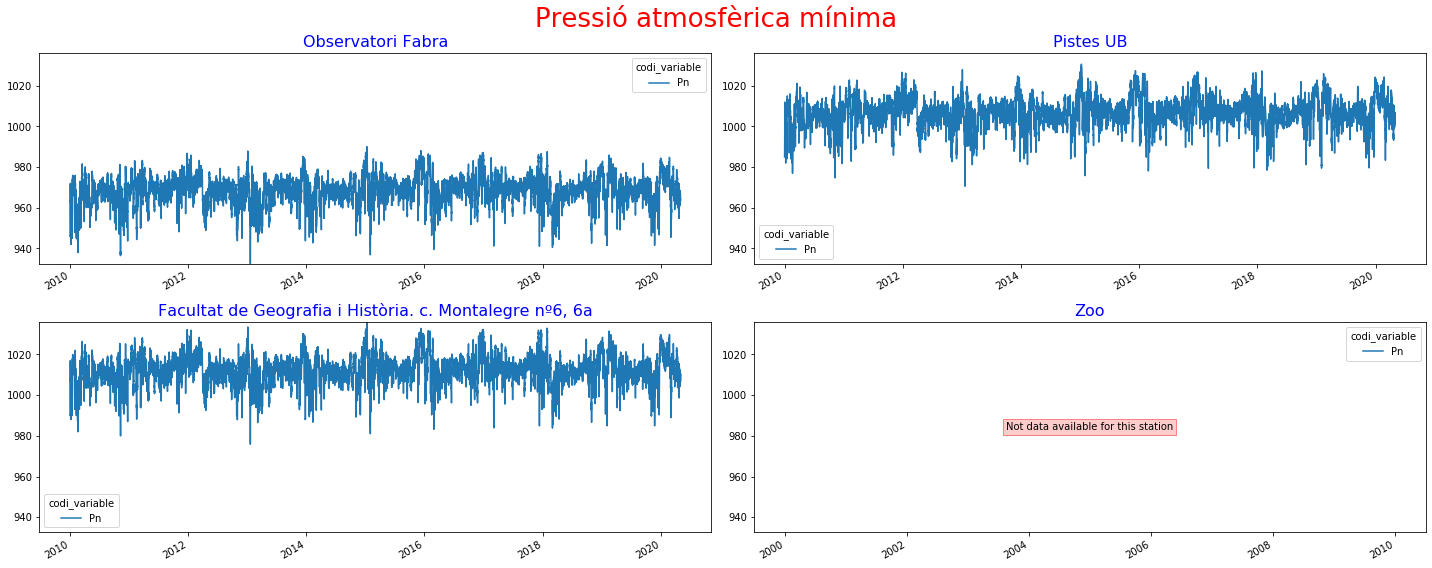

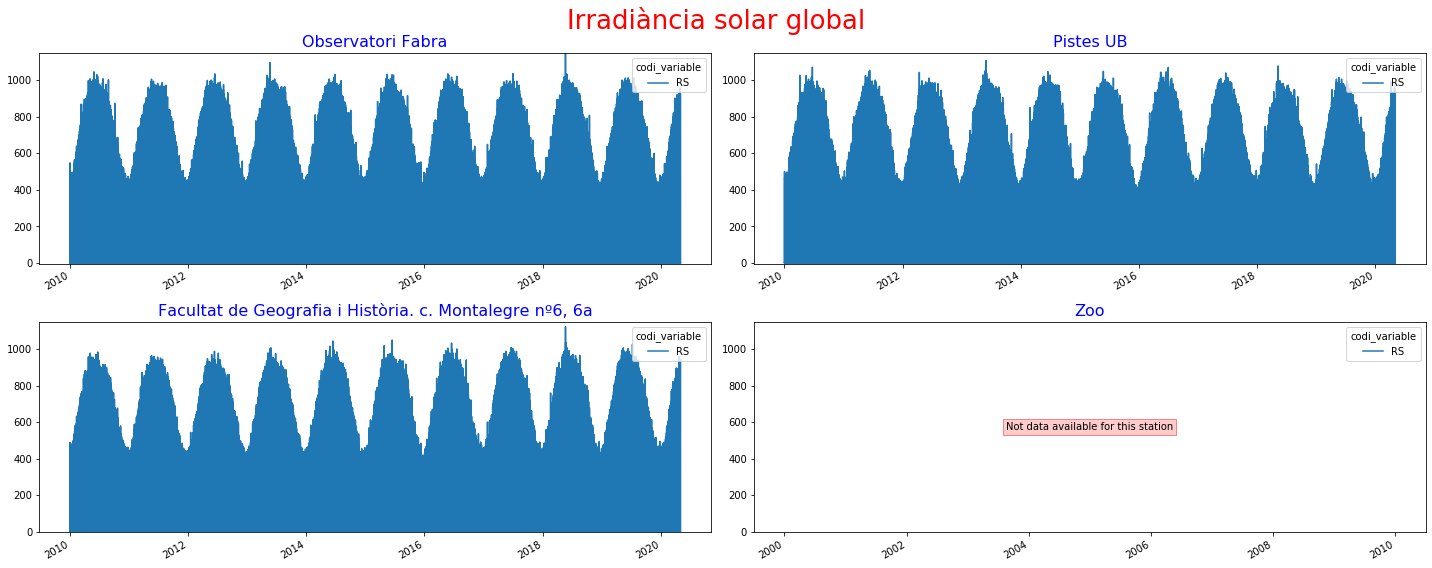

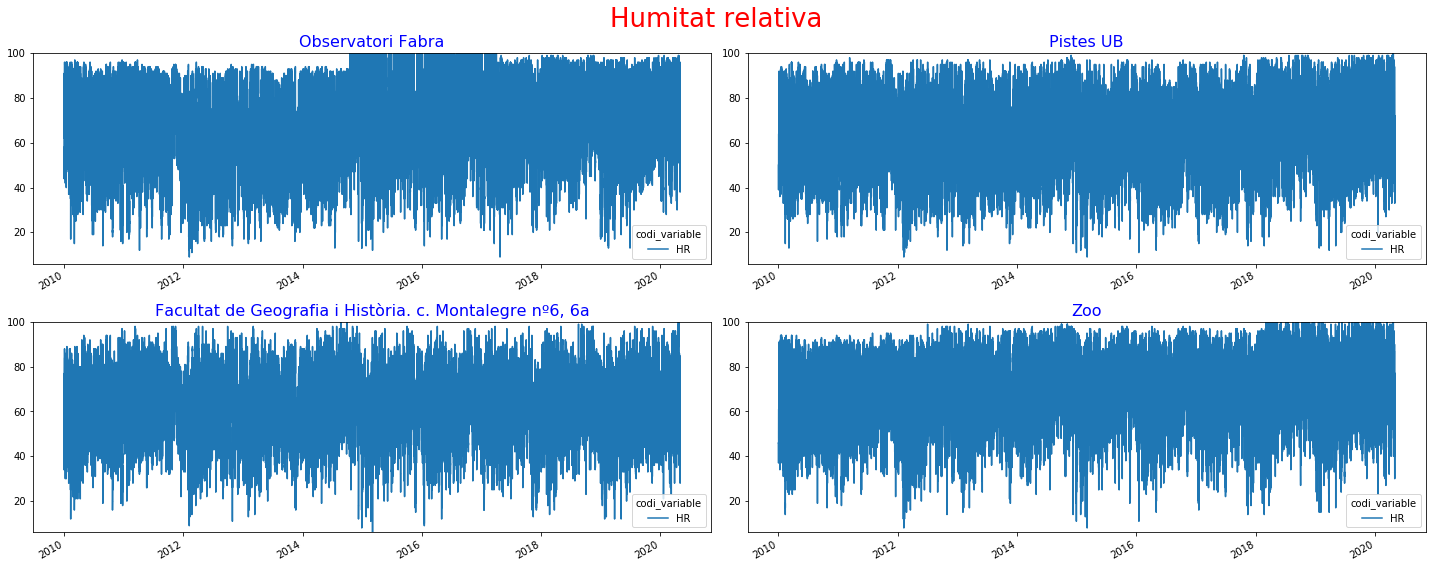

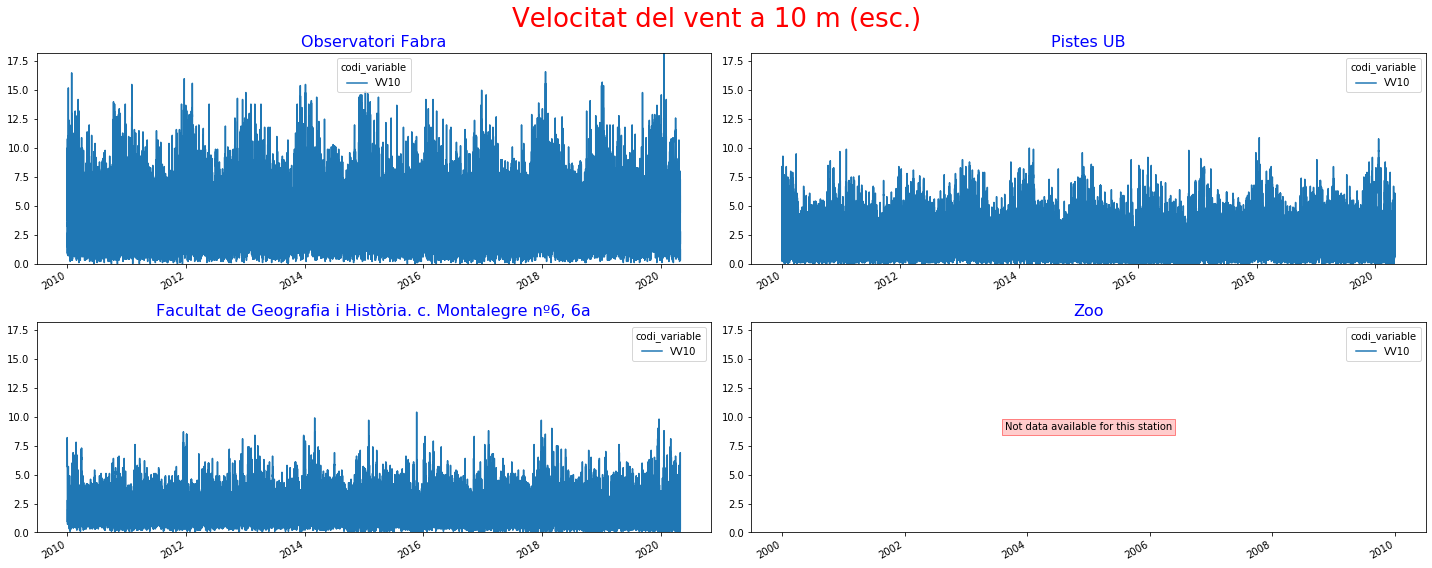

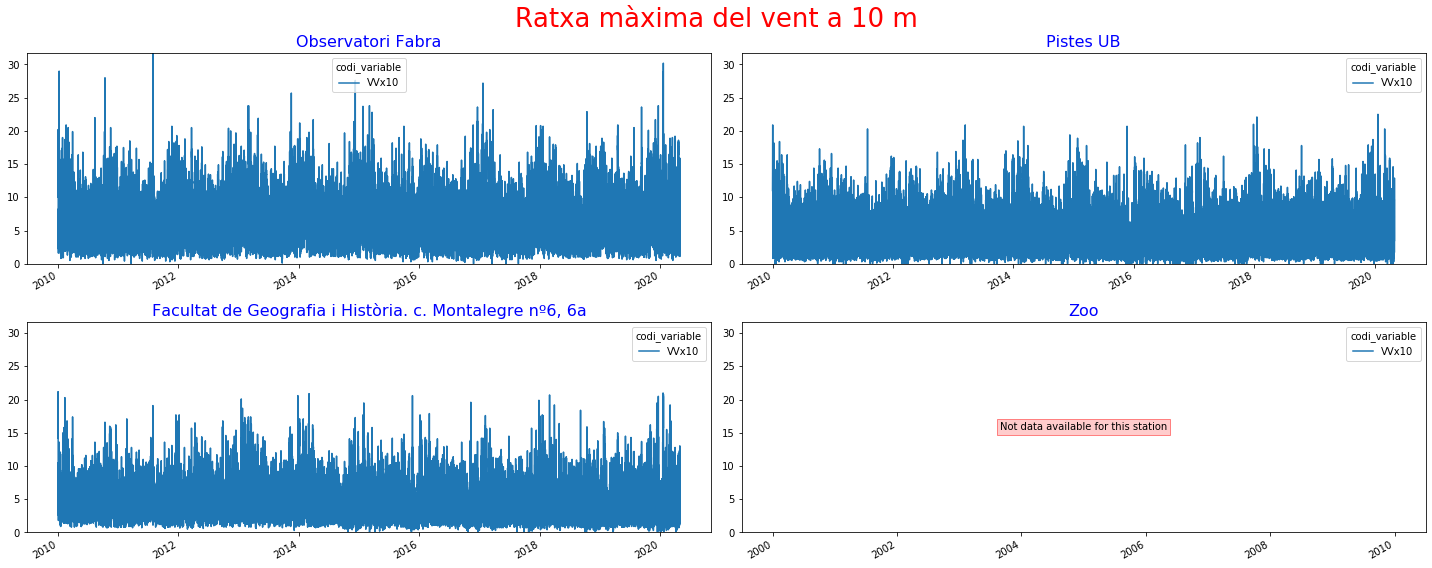

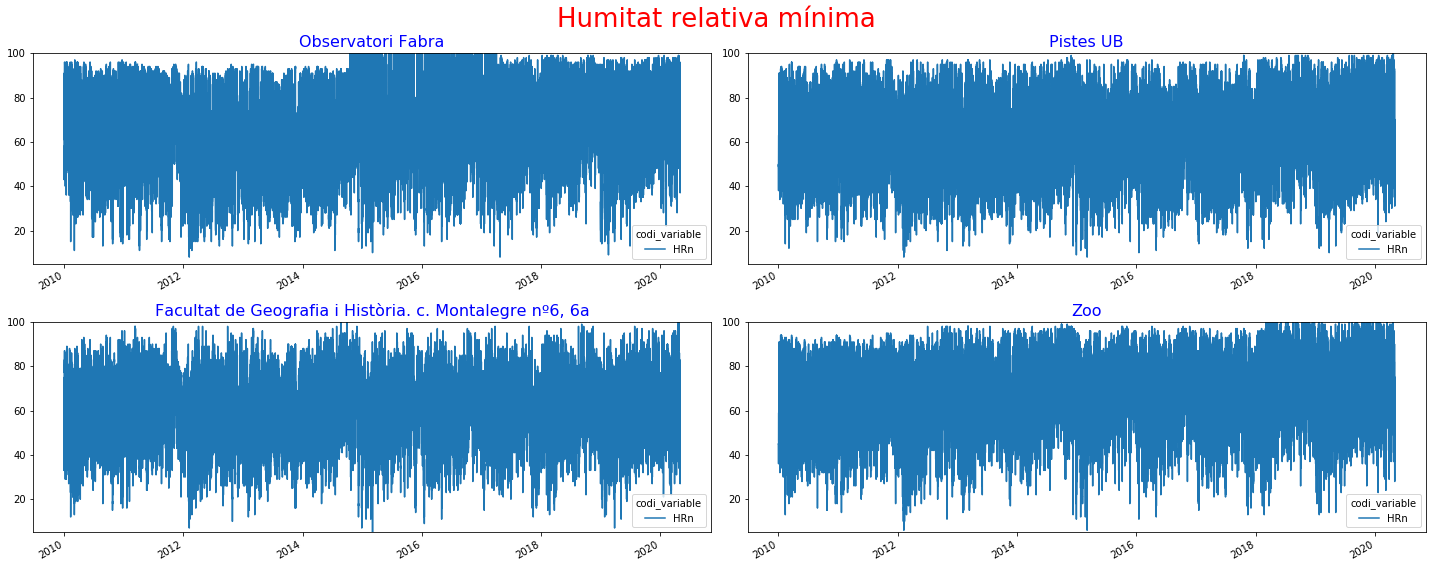

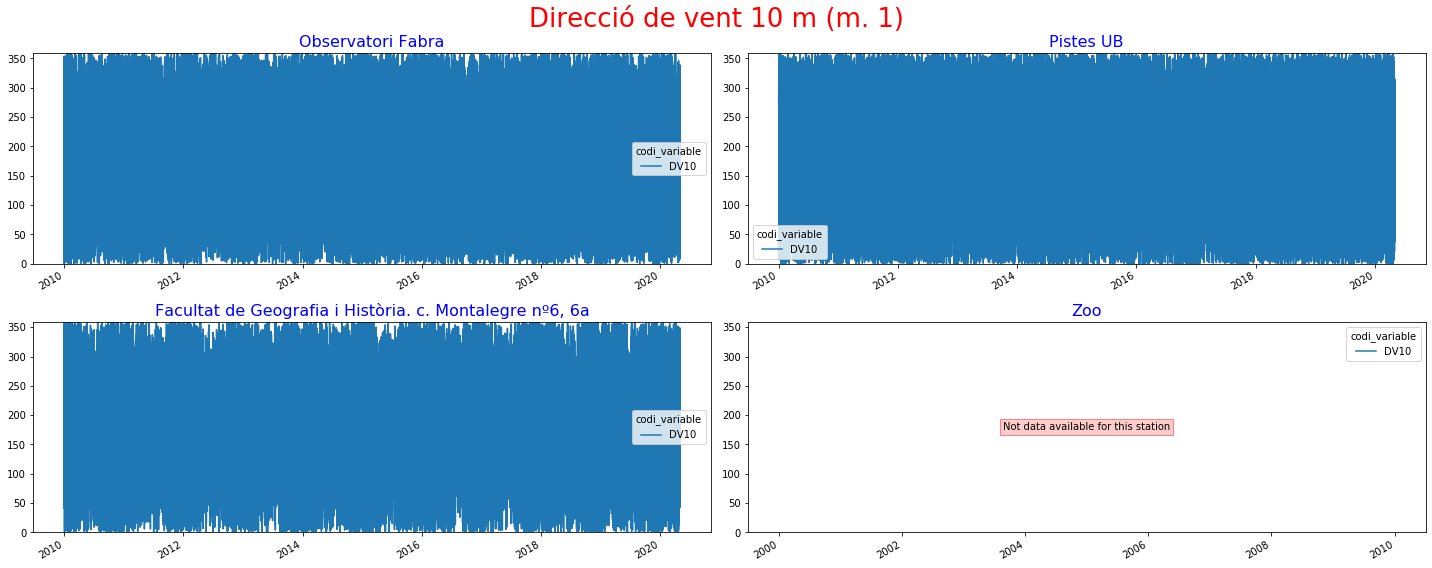

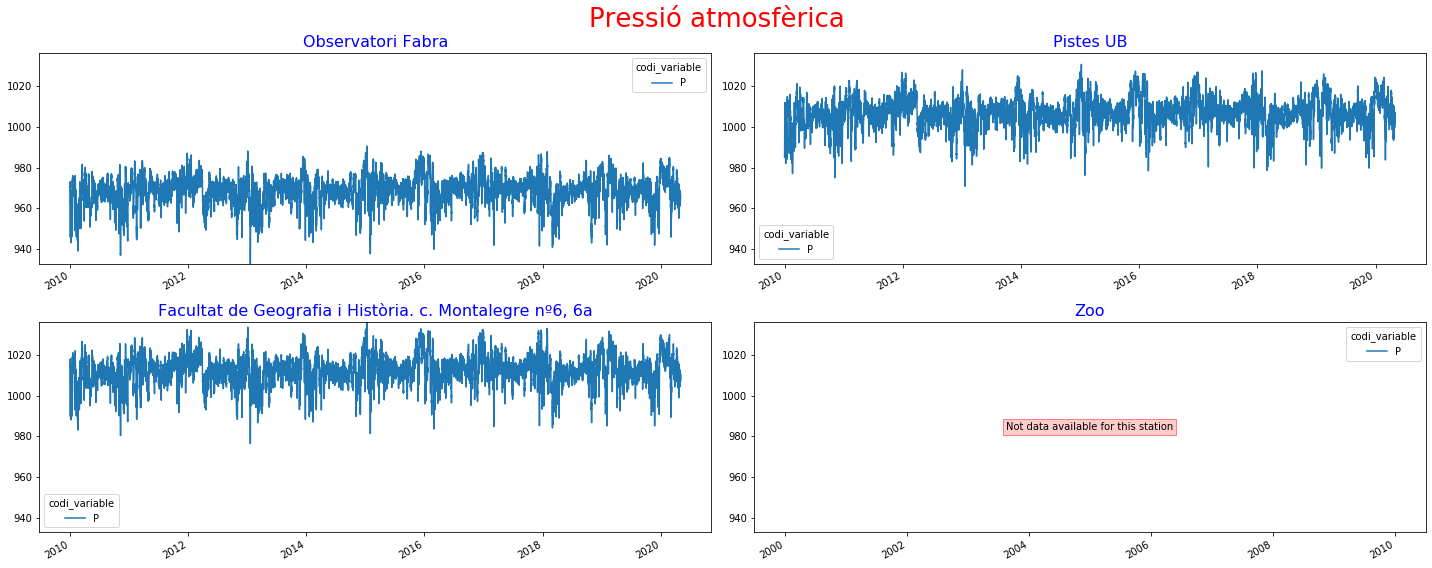

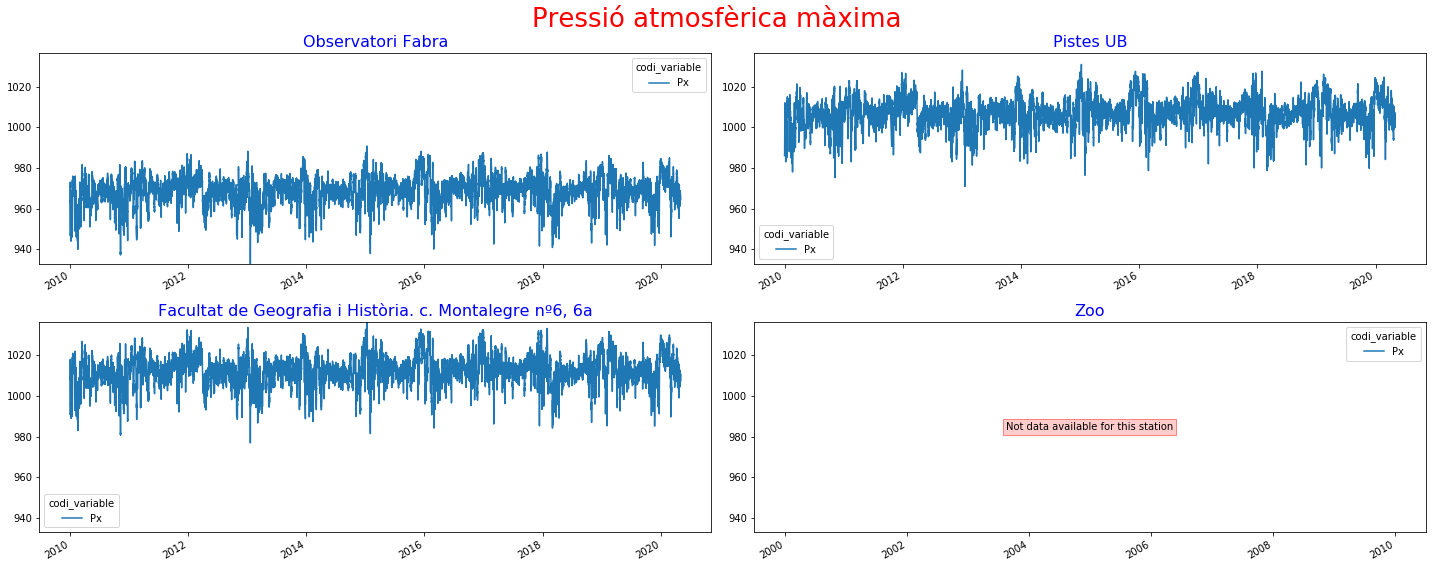

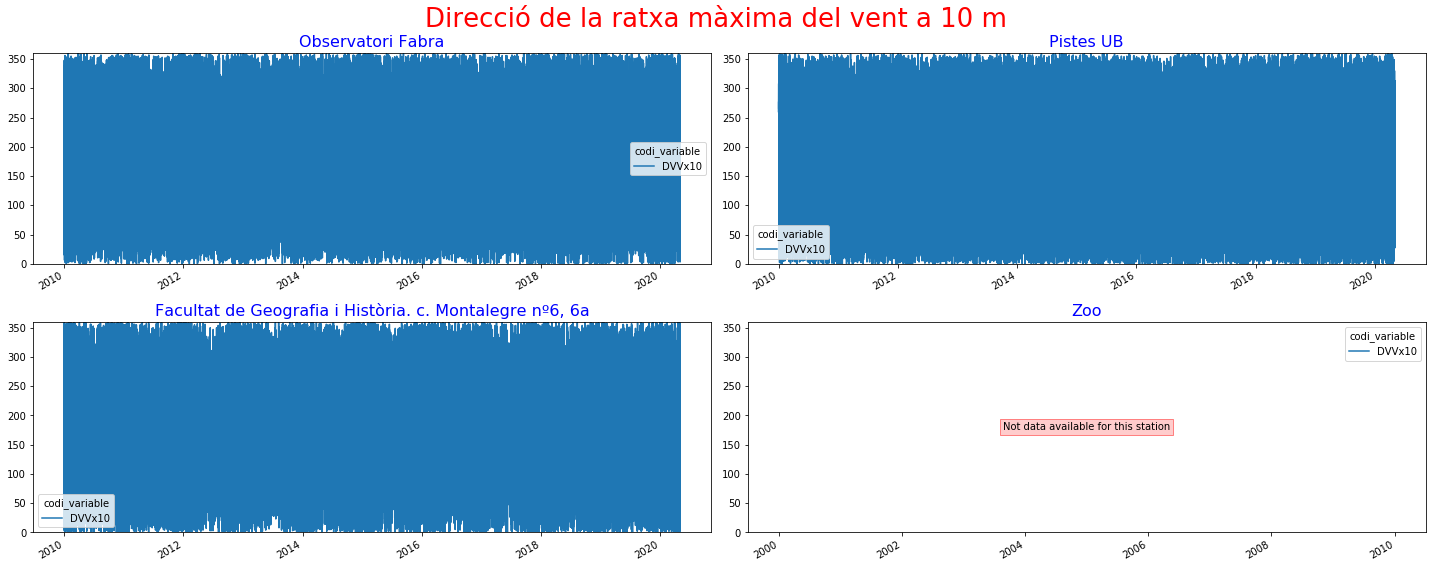

In [26]:
idStations = data_meteo_hourly['codi_estacio'].unique()
nroItems=len(idStations)
ncols=2
nrows=int((nroItems / ncols) + (nroItems % ncols))

idStations=np.append(idStations, [None] * (nroItems % ncols))

variables=data_meteo['codi_variable'].unique()
#variables=np.array(['DV10', 'DVVx10','HR','HRn','HRx','P','PPT','PPTx1min','Pn','Px','RS','T','Tn','Tx','VV10','VVx10'])

for variable in variables:
    nom_variable=meteoVariables.loc[meteoVariables["acronim"] == variable,'nom_variable'].iloc[0]
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*10,nrows*4))
    for idStation, ax in zip(idStations, axes.flatten()) :
        if idStation:
            nom_estacio=data_meteo_stations.loc[data_meteo_stations['codi_estacio'] == idStation,'emplacament'].iloc[0]
            title='{}'.format(nom_estacio)
            data=data_meteo_hourly.loc[(data_meteo_hourly["codi_estacio"] == idStation), ['data_lectura', variable]].set_index('data_lectura')
            if data.count()[0] > 0:  
                data.plot(ax=ax)     
                ax.set_ylim(stats[variable]['min'],stats[variable]['max'])
                ax.set_title(title, fontsize=16, color='blue')
                ax.set_xlabel('')
            else:
                data.plot(ax=ax)
                text='Not data available for this station'
                ax.text(0.5, 0.5, text, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,
                        bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
                #plt.text(5, 5, text, ha='right', rotation=-15, wrap=True)
                ax.set_ylim(stats[variable]['min'],stats[variable]['max'])
                ax.set_title(title, fontsize=16, color='blue')
                ax.set_xlabel('')
        else:
            ax.remove()
        
    plt.suptitle('{}'.format(nom_variable), fontsize=26, color='red')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Vemos que los registros para cada variable observada, en cada una de las estaciones, son bastante similares. Observamos, también que hay una estación (Zoo) en la cual no se realiza medida para varias de los parámetros meteorológicos. Probablemente esto sea debido a que esta estación no está dotada de los instrumentos de medida apropiados para realizar tales mediciones.

# 3. Selección de estaciones

Como hemos visto en las gráficas anteriores, la estación de Zoo no registra datos para algunas de las variables meteorológicas. Además esta estación se encuentra muy próxima a la estación de la Facultad de Geografía e Historia. Por lo tanto, podríamos optar por prescindir de los datos de esta estación para nuestros estudios posteriores. 

En la tabla de abajo mostramos, para cada estación meteorológica, las fechas de inicial y final para las que tenemos valores de cada variable registrada. 

In [27]:
datas = pd.DataFrame()
stations=data_meteo_hourly['codi_estacio'].unique()
variables=data_meteo_hourly.columns[2:]
for variable in variables:
    row = {'variable':[variable]}
    for station in stations:
        data=data_meteo_hourly.loc[data_meteo_hourly['codi_estacio'] == station,].set_index('data_lectura')
        ts = pd.Series(data[variable].values, index=data.index)
        row[station+'_first'] = [ts.first_valid_index()]
        row[station+'_last'] = [ts.last_valid_index()]
    datas = datas.append(pd.DataFrame.from_dict(row), ignore_index=True, sort=False)
datas

,variable,D5_first,D5_last,X8_first,X8_last,X4_first,X4_last,X2_first,X2_last
0,DV10,2010-01-01,2020-04-30 23:00:00,2010-01-01,2020-04-30 23:00:00,2010-01-01,2020-04-30 23:00:00,None,None
1,DVVx10,2010-01-01,2020-04-30 23:00:00,2010-01-01,2020-04-30 23:00:00,2010-01-01,2020-04-30 23:00:00,None,None
2,HR,2010-01-01,2020-04-30 23:00:00,2010-01-01,2020-04-30 23:00:00,2010-01-01,2020-04-30 23:00:00,2010-01-01 00:00:00,2020-04-30 23:00:00
3,HRn,2010-01-01,2020-04-30 23:00:00,2010-01-01,2020-04-30 23:00:00,2010-01-01,2020-04-30 23:00:00,2010-01-01 00:00:00,2020-04-30 23:00:00
4,HRx,2010-01-01,2020-04-30 23:00:00,2010-01-01,2020-04-30 23:00:00,2010-01-01,2020-04-30 23:00:00,2010-01-01 00:00:00,2020-04-30 23:00:00
5,P,2010-01-01,2020-04-30 23:00:00,2010-01-01,2020-04-30 23:00:00,2010-01-01,2020-04-30 23:00:00,None,None
6,PPT,2010-01-01,2020-04-30 23:00:00,2010-01-01,2020-04-30 23:00:00,2010-01-01,2020-04-30 23:00:00,None,None
7,PPTx1min,2010-01-01,2020-04-30 23:00:00,2010-01-01,2020-04-30 23:00:00,2010-01-01,2020-04-30 23:00:00,None,None
8,Pn,2010-01-01,2020-04-30 23:00:00,2010-01-01,2020-04-30 23:00:00,2010-01-01,2020-04-30 23:00:00,None,None
9,Px,2010-01-01,2020-04-30 23:00:00,2010-01-01,2020-04-30 23:00:00,2010-01-01,2020-04-30 23:00:00,None,None


Como podemos confirmar en la tabla de arriba, la estación de Zoo (X2) solamente contiene datos para las variables asociadas con la humedad relativa y temperatura media, mínima y máxima, en ambos casos, es decir: HR, HRn, HRx, T, Tn y Tx. 

Eliminaremos esta estación de nuestros datos con el fin de reducir un poco el tamaño de estos.

In [28]:
codiStations = ['X2']
data_meteo_hourly_red = data_meteo_hourly[data_meteo_hourly['codi_estacio'].map(lambda x: x not in codiStations)]
data_meteo_hourly_red.head()

codi_variable,codi_estacio,data_lectura,DV10,DVVx10,HR,HRn,HRx,P,PPT,PPTx1min,Pn,Px,RS,T,Tn,Tx,VV10,VVx10
0,D5,2010-01-01 00:00:00,235.0,261.0,57.0,56.0,58.0,946.0,0.0,0.0,946.0,947.0,0.0,8.2,8.0,8.3,9.7,17.3
271440,X8,2010-01-01 00:00:00,273.0,276.0,50.0,49.0,51.0,985.0,0.0,0.0,985.0,986.0,0.0,11.2,11.0,11.4,6.1,11.1
180959,X4,2010-01-01 00:00:00,276.0,280.0,44.0,43.0,46.0,990.0,0.0,0.0,990.0,991.0,0.0,12.1,11.8,12.4,5.7,15.6
271441,X8,2010-01-01 01:00:00,282.0,259.0,49.0,49.0,50.0,986.0,0.0,0.0,985.0,986.0,0.0,10.5,10.4,10.7,5.6,12.1
180960,X4,2010-01-01 01:00:00,290.0,305.0,44.0,43.0,46.0,991.0,0.0,0.0,990.0,991.0,0.0,11.5,11.2,11.8,7.2,16.1


Guardamos el nuevo dataframe en un fichero:

In [29]:
data_meteo_hourly_red.to_csv(r'../data/data_meteo_hourly_red.csv', index = False)

# Bibliografía

- Numpy developer manual. https://numpy.org/devdocs/

- Pandas documentation. https://pandas.pydata.org/docs/

- Folium. https://python-visualization.github.io/folium/